# NATS3200: Machine learning approaches for scientific analysis
## Lecturer: Dr Stefan Auer, School of Chemistry, University of Leeds

## Standard errors and confidence intervals

Lets consider data generated from a very simple linear model with a zero intercept. I will assume a gradient, $\beta$ of 2 and a variance of $3^2$.These are just arbitrary numbers for the purposes of illustration.
$$
Y = \beta X + \epsilon, \ \epsilon \sim \mathcal{N}(0, \sigma^2=3^2), \ \beta = 2
\tag{19}
$$
We can generate data from this model simply in Python, taking a random sample of $X$ values between 0 and 10

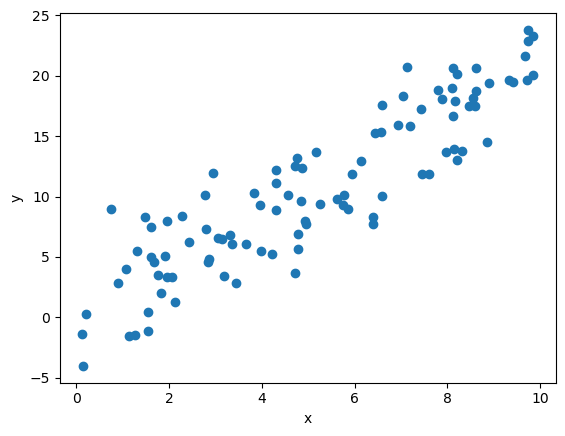

(100,)
(100,)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
#x=np.arange(0,10,1/10)
x = np.random.uniform(0,10,100)
mu, sigma = 0, 3 # mean and standard deviation
s = np.random.normal(mu,sigma,100)
y=2*x+s
plt.scatter(x,y, marker="o")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
print(x.shape)
print(y.shape)

### Doing linear regression in practice: the glm command  

In [2]:
import pandas as pd
df=pd.DataFrame({'INPUT': x,'OUTPUT':y})
df.head()

,INPUT,OUTPUT
0,0.748681,8.979341
1,2.788944,7.299947
2,9.727458,22.848135
3,7.187033,15.883959
4,6.574938,15.313665


In [3]:
from statsmodels.formula.api import glm
formula = 'OUTPUT ~ INPUT'
my_multiple_data = glm(formula, df).fit()
print(my_multiple_data.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 OUTPUT   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          8.4044
Method:                          IRLS   Log-Likelihood:                -247.32
Date:                Fri, 10 Feb 2023   Deviance:                       823.63
Time:                        11:18:23   Pearson chi2:                     824.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9843
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1199      0.602     -0.199      0.8

The summary provided gives us lots of information. For the moment we are most interested in the values of the coefficients, which match closely to those we found by doing our own optimisation before. Note as well that the summary provides 'standard errors' for each coefficient. These tell us how uncertain we are about each the value of coefficient. You can think of each estimate of a coefficient being a random variable whose value is normally distributed. The standard error is the estimated standard deviation of this distribution. Let's try this out.

## Calculation of the standard error of the regression coefficients 
The above fit gives us the best estimate for the coefficients, but we would like to know how much this estimate would vary if we were to repeat the experiment, i.e. if we were to select data points with the same input values, but which would have different values y because of the random variation of the residuals, $\epsilon$. This can be simply done by repeating the experiment N times.

In [4]:
import statistics
#Define lists to store the coefficients obtained from the fit for each experiment
m0 = []
m1 = []

N=1000 # Number of repeat experiments
n=100  

for i in range(1,N):

    s = np.random.normal(mu,sigma,n)
    y=2*x+s
    df=pd.DataFrame({'INPUT': x,'OUTPUT':y})
    formula = 'OUTPUT ~ INPUT'
    model = glm(formula, df).fit()
    m0.append(model.params[0])
    m1.append(model.params[1])

# Calculate the mean of each coefficient and its standard deviation
mean_m0=statistics.mean(m0)
mean_m1=statistics.mean(m1)
stdev_m0=statistics.stdev(m0)
stdev_m1=statistics.stdev(m1)

print("Mean and standard deviation for intercept", mean_m0,stdev_m0)
print("Mean and standard deviation for slope", mean_m1,stdev_m1)

Mean and standard deviation for intercept -0.015498354285421116 0.6171069983455054
Mean and standard deviation for slope 1.9988605802885522 0.1054381590666343


The estimate for the standard error agree with the one obtained from the glm summary above. According to the Central limit theorem, the estimates for the coefficients are normally distributed, and we can fit our obtained values to a normal distribution to obtain the corresponding values for the mean and standard deviation. 

## Distribution function for the coefficients and estimate mean and standard deviation

Lets start with the intercept. First I fit our obtained values for the intercept to a normal distribution to obtain the mean and standard deviation. 

In [8]:
from scipy import optimize
def lognorm(param,Y):
    mean,var = param
    return (-N*np.log(np.sqrt(2*np.pi)*var) -np.sum((Y-mean)**2/(2*var**2)))

def neg_LL(param):
    return -lognorm(param,m0)

start_guess = [0,0]
mle_result = optimize.fmin(neg_LL,start_guess);
print("MLE mean = ", mle_result[0]);
print("MLE standard deviation = ", mle_result[1]);

Optimization terminated successfully.
         Current function value: 935.224681
         Iterations: 65
         Function evaluations: 124
MLE mean =  -0.015460103006723177
MLE standard deviation =  0.6164994170404288


/var/folders/8p/c42g9rw13sd3qd1h03v6g26c0000gn/T/ipykernel_40977/312502249.py:4: RuntimeWarning: divide by zero encountered in log
  return (-N*np.log(np.sqrt(2*np.pi)*var) -np.sum((Y-mean)**2/(2*var**2)))
/var/folders/8p/c42g9rw13sd3qd1h03v6g26c0000gn/T/ipykernel_40977/312502249.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return (-N*np.log(np.sqrt(2*np.pi)*var) -np.sum((Y-mean)**2/(2*var**2)))
/var/folders/8p/c42g9rw13sd3qd1h03v6g26c0000gn/T/ipykernel_40977/312502249.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return (-N*np.log(np.sqrt(2*np.pi)*var) -np.sum((Y-mean)**2/(2*var**2)))


As can be seen, the estimates for the mean and standard deviation agree well. Next I depict the histogram of the values obtained for the intercept, and plot the normal distribution using the mean and standard deviation obtained from the fit above. 

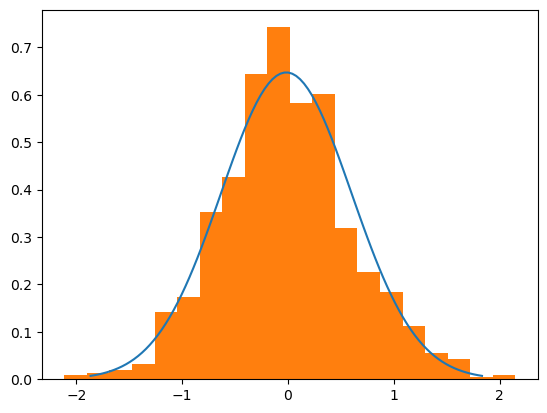

In [9]:
import scipy 
mu = mle_result[0]
sigma = mle_result[1]
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, scipy.stats.norm.pdf(x,mu,sigma))
plt.hist(m0,bins=20,density=True)
plt.show()

The good agreement can be seen. I repeat this for the slope 

In [10]:
def neg_LLm(param):
    return -lognorm(param,m1)

start_guess = [0,0]
mle_result = optimize.fmin(neg_LLm,start_guess)
print("MLE mean = ", mle_result[0])
print("MLE standard deviation = ", mle_result[1])

Optimization terminated successfully.
         Current function value: -831.693078
         Iterations: 78
         Function evaluations: 148
MLE mean =  1.998896540574973
MLE standard deviation =  0.10533141642204555


/var/folders/8p/c42g9rw13sd3qd1h03v6g26c0000gn/T/ipykernel_40977/312502249.py:4: RuntimeWarning: divide by zero encountered in log
  return (-N*np.log(np.sqrt(2*np.pi)*var) -np.sum((Y-mean)**2/(2*var**2)))
/var/folders/8p/c42g9rw13sd3qd1h03v6g26c0000gn/T/ipykernel_40977/312502249.py:4: RuntimeWarning: divide by zero encountered in true_divide
  return (-N*np.log(np.sqrt(2*np.pi)*var) -np.sum((Y-mean)**2/(2*var**2)))
/var/folders/8p/c42g9rw13sd3qd1h03v6g26c0000gn/T/ipykernel_40977/312502249.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return (-N*np.log(np.sqrt(2*np.pi)*var) -np.sum((Y-mean)**2/(2*var**2)))
/var/folders/8p/c42g9rw13sd3qd1h03v6g26c0000gn/T/ipykernel_40977/312502249.py:4: RuntimeWarning: invalid value encountered in log
  return (-N*np.log(np.sqrt(2*np.pi)*var) -np.sum((Y-mean)**2/(2*var**2)))


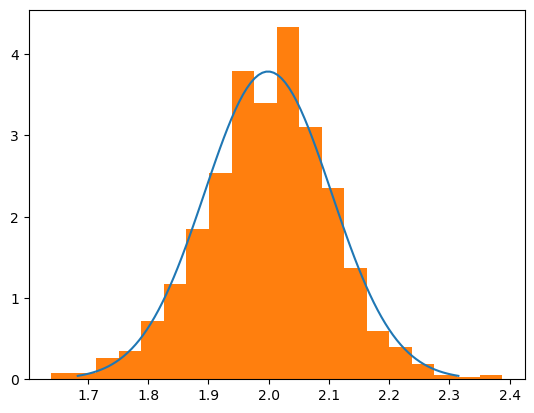

In [11]:
mu = mle_result[0]
sigma = mle_result[1]
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, scipy.stats.norm.pdf(x,mu,sigma))
plt.hist(m1,bins=20,density=True)
plt.show()

## Conficence intervals 

We can therefore construct 95\% (or any percentile) confidence intervals for the true coefficient value using this.  You use the data provided to estimate the population mean (simply the mean of your data), and the standard error (the sample variance divided by the number of observation in the data, $n$). From this you construct an interval. For example, for a 95\% C.I. that interval is: sample mean $\pm$ standard error $\times t_{2.5\%, n-1}$, where $t_{2.5\%, n-1}$ indicate the critical value for a t-distribution with $n-1$ degrees of freedom where $P(x > t_{2.5\%, n-1}) = 0.025$. Recall that we use a t-distribution when sample sizes are small (generally $n < 50$), to account for the extra uncertainty this introduces - as $n$ grows beyond 50 it rapidly, $t_{2.5\%, n-1}$ rapidly tends towards a stable value of around 1.96. We used a t-distribution with $n-1$ degrees of freedom because when we estimate the *variance* of the population from the data we have only $n-1$ independent data points; because the mean was also estimated from the data, then if we are given the mean and $n-1$ of the observations we can always reconstruct the $n$th value.

In the case of the linear regression coefficients, we can follow a very similar process to construct confidence intervals for the estimates of the coefficient values. The key difference is to recognise that we have further reduced the number of effectively independent data points, the degrees of freedom, in estimating the standard error. This is because we have estimated both the intercept value, $\beta_0$, and the gradient, $\beta_1$, before we use these to generate the estimate of the variance. Therefore the number of degrees of freedom is reduced to $n-2$. If you were to give me $n-2$ of the observations, along with the estimated values of $\beta_0$ and $\beta_1$, I could always tell you what the missing two observations were. Therefore the 95\% C.I. for any regression coefficient in this one-dimensional model is:

**estimate $\pm$ standard error $\times t_{2.5\%, n-2}$**

These confidence intervals work exactly the same as those you will have learnt in NATS2380: we intepret them as meaning that there is a $\alpha$\% probability that the real coefficient value lies within the $\alpha$\% confidence interval. In most practical appications we will almost always use $\alpha=95$ (as above), though you can easily adapt for any desired interval by finding the appropriate critical t-value.

In [12]:
alpha=0.05
t_critical=scipy.stats.norm.ppf(1 - alpha / 2) 

print(t_critical,mle_result[0]-t_critical*mle_result[1],mle_result[0]+t_critical*mle_result[1])

1.959963984540054 1.792450757947173 2.205342323202773


### Integration over distribution function 

In [13]:
import scipy.integrate as integrate
# Define mu and sigma
mu = mle_result[0]
sigma = mle_result[1]

# Define bounds of integral
a = mle_result[0]-t_critical*mle_result[1]
b = mle_result[0]+t_critical*mle_result[1]

# Generate function values
x_range = np.linspace(a,b,100)
fx = scipy.stats.norm.pdf(x_range,mu,sigma)

integrate.simps(fx,x_range)

0.9500008661111714

#### The integration confirms that the limits calculated for the 95 percent confidence interval correspond to the 95 percent probability. 